In [1]:
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import genextreme as gev

from pyextremes import EVA
import gdown

In [2]:
#'GOOGLE_DRIVE_LINK' to NetCDF file
url = 'https://drive.google.com/file/d/1ljDfwAeyfLNMsArQDOFP9-7y4EC7Brxq/view?usp=drive_link'
# Download the NetCDF file
file_path = 'data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc'
gdown.download(url, file_path, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1ljDfwAeyfLNMsArQDOFP9-7y4EC7Brxq
To: /home/mlanger/Dokumente/Lehre/Earth science observation research methods/scripts/notebooks/data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc
100%|██████████████████████████████████████| 6.06M/6.06M [00:00<00:00, 10.2MB/s]


'data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc'

In [3]:
# Load the ERA5 reanalysis daily precipitation data for Tenerife from 1950 - 2000 
#file_path = 'data/input/ERA5_Tenerife_total_precipitation_day_1950_2000.nc'

daily_precipitation = xr.open_dataset(file_path)
# Add an attribute to the dataset
daily_precipitation.attrs['units'] = 'mm/d'
# create a array which only conains the years 
years = daily_precipitation['time'].dt.year.values

# Print the loaded data base
daily_precipitation

<xarray.Dataset>
Dimensions:    (time: 18679, bnds: 2, longitude: 5, latitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 1949-12-31T23:00:00 ... 2000-12-31T11:00:00
  * longitude  (longitude) float32 -17.0 -16.75 -16.5 -16.25 -16.0
  * latitude   (latitude) float32 28.75 28.5 28.25 28.0 27.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    tp         (time, latitude, longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Mon Jan 08 10:54:24 2024: cdo -b F64 -daysum -shifttime,-1s...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...
    units:        mm/d

In [4]:
# Select on grid cell accroding to coordinates 
latitude_target = 28.25
longitude_target = -16.76
daily_precipitation = daily_precipitation.sel(latitude=latitude_target, longitude=longitude_target, method='nearest')

In [5]:
# Calculate monthly sums
monthly_sum_precipitation = daily_precipitation.resample(time='1m').sum(dim='time')
# Calaculate a mean of monthly sums from the years
annual_mean_precipitation_monthly_sum = monthly_sum_precipitation.groupby('time.month').mean(dim='time')


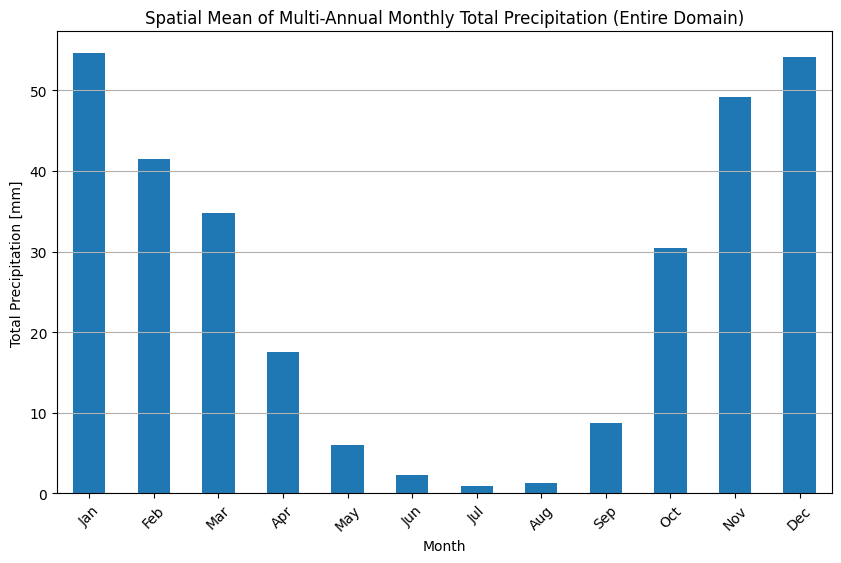

In [6]:
# Convert DataArray to pandas DataFrame for easier plotting
df = annual_mean_precipitation_monthly_sum.to_dataframe()

# Plot mean monthly precipitation of multi-annual means as a bar plot
df['tp'].plot(kind='bar', figsize=(10, 6))
plt.title('Spatial Mean of Multi-Annual Monthly Total Precipitation (Entire Domain)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation [mm]')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y')
plt.show()

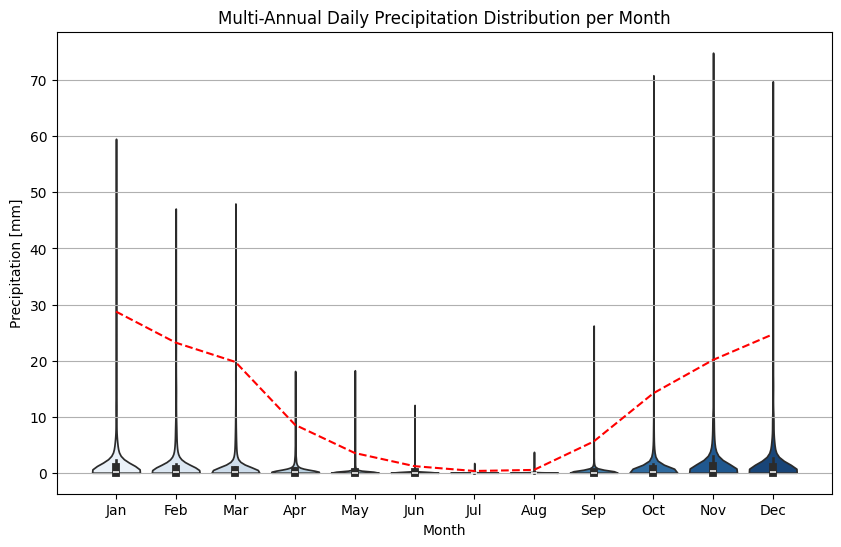

In [7]:
# A diffrent way of ploting the precipitation allows us to learn something
# about distribution of values within the months

# First calaculate spatial mean for daily values which are grouped by month
spatial_mean_daily_precipitation_monthly = daily_precipitation['tp'].groupby('time.month')

# Prepare data for violin plots (daily values must be stored in lists for every month)
data_list = []
data_99p_list = []
months = range(1, 13)  # Months range from 1 to 12
for m in months:
    # Extract data for each month
    data_month = spatial_mean_daily_precipitation_monthly[m]  
    # Calaculate 99% percentile for each month
    data_month_99p = data_month.reduce(np.percentile, q=99, dim='time')   
    # store data into lists for each month 
    data_list.append(data_month.values)
    data_99p_list.append(data_month_99p.values)
    
# Create violin plots we use the seaborn libary
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_list, cut=0, palette="Blues")
plt.title('Multi-Annual Daily Precipitation Distribution per Month')
plt.xlabel('Month')
plt.ylabel('Precipitation [mm]')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')

plt.plot(np.arange(0,12,1),data_99p_list, color='r', linestyle='--', label=f'99th Percentile')
plt.show()

In [8]:
# Optain array of precipitation data from the xarray
daily_mean = daily_precipitation['tp']

# filter out only wet days (daily precipitation > 1mm)
daily_mean_wet = daily_mean[(daily_mean > 1)]
daily_mean_dry = daily_mean[(daily_mean <= 1)]

n_days = daily_mean.size
n_wet_days = daily_mean_wet.size
n_dry_days = daily_mean_dry.size

p_wet_day = n_wet_days/n_days

print(f'In total there are {n_wet_days:.0f} wet days out of {n_days:.0f} observations')
print(f'The mean daily propabilty of wet day is {p_wet_day:.2f} dry days out of {n_days:.0f} observations')

In total there are 2482 wet days out of 18679 observations
The mean daily propabilty of wet day is 0.13 dry days out of 18679 observations


In [9]:
# Calculate mean, median, and percentiles
mean_precip = daily_mean_wet.mean().values
median_precip = np.nanmedian(daily_mean_wet.values)
percentile_95 = np.nanpercentile(daily_mean_wet.values, 95)
percentile_99 = np.nanpercentile(daily_mean_wet.values, 99)

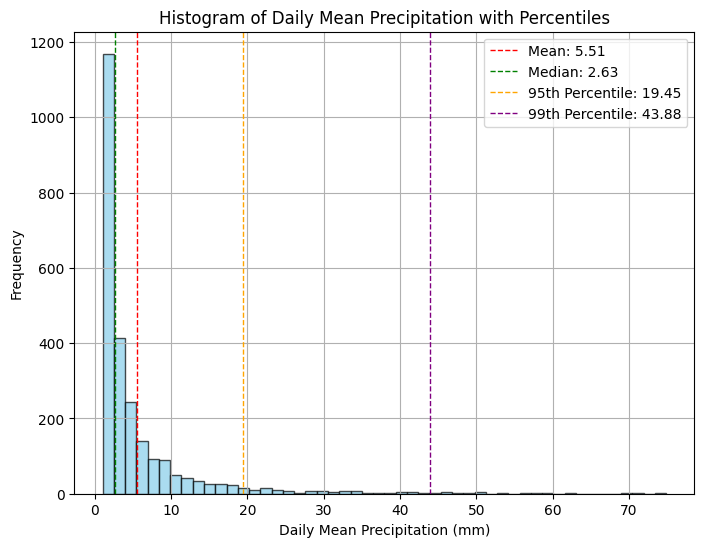

In [10]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(daily_mean_wet, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

# Add lines for mean, median, and percentiles
plt.axvline(mean_precip, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_precip:.2f}')
plt.axvline(median_precip, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_precip:.2f}')
plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=1, label=f'95th Percentile: {percentile_95:.2f}')
plt.axvline(percentile_99, color='purple', linestyle='dashed', linewidth=1, label=f'99th Percentile: {percentile_99:.2f}')

# Plot legend, labels, and title
plt.legend()
plt.xlabel('Daily Mean Precipitation (mm)')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Mean Precipitation with Percentiles')
plt.grid(True)
plt.show()

In [11]:
# Create a DataFrame for better organization and visualization
df = pd.DataFrame({'Date': daily_mean_wet['time'], 'DailyRecords': daily_mean_wet.values})
df

,Date,DailyRecords
0,1950-01-08 12:00:00,2.924730
1,1950-01-18 12:00:00,1.014810
2,1950-01-21 12:00:00,1.393316
3,1950-01-27 12:00:00,9.997056
4,1950-01-28 12:00:00,6.139810
...,...,...
2477,2000-12-22 12:00:00,2.953605
2478,2000-12-23 12:00:00,7.686567
2479,2000-12-24 12:00:00,1.586572
2480,2000-12-25 12:00:00,2.338617


Perform the following analysis based on the theoretical example from the lecture:

 - Fit a well-suited distribution function to the (non-zero) precipitation data.
 - Calculate the return period for events > 30 mm. Note that the model is based on wet days only, but that there is a large fraction of dry days, which affects the resulting annual probability.
 - Apply the block maximum method and calculate the return period for events > 30 mm.
 

In [14]:
# Fit a gamma distribution to the wet day precipitation records:
fit_alpha, fit_loc, fit_beta = gamma.fit(df['DailyRecords'])

Text(0, 0.5, 'Frequency')

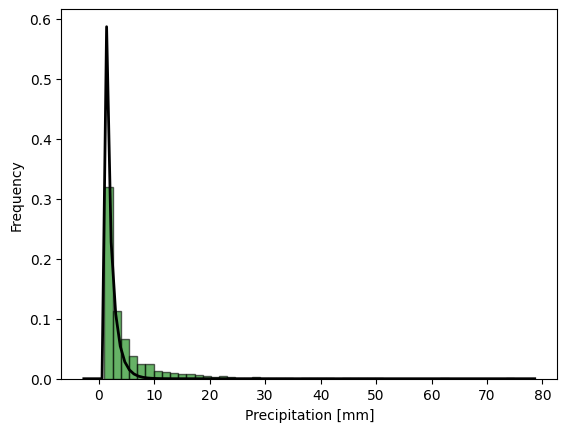

In [15]:
# Create a histogram
plt.hist(df['DailyRecords'], bins=50, density=True, alpha=0.6, color='g', edgecolor='black')

# Plot the fitted function on top
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Precipitation [mm]')
plt.ylabel('Frequency')

In [16]:
# If we select a treshold we can model the return period based on the fitted distribution function
event_threshold = 30 #mm
# Optain the daily probability of threshold exeedance 
p_daily = p_wet_day * (1 - gamma(fit_alpha, fit_loc, fit_beta).cdf(event_threshold))
# Transfrom this to an annual probability
p_annual = 1 - (1 - p_daily)**365 
# Claculate return period
return_period_model = 1/p_annual
# Print result
print(p_annual)
print(return_period_model)

2.0788938126514722e-08
48102504.991564505


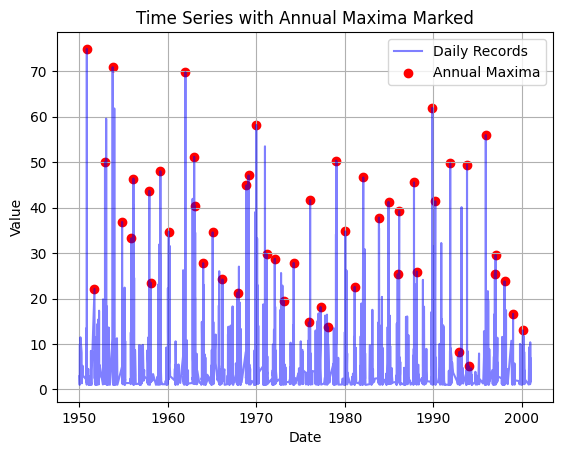

In [17]:
# Now we use an approach from Extreme Value Analysis

# Extract year from the 'Date' column
df['Year'] = df['Date'].dt.year

# Find annual maxima and corresponding dates (Block Maximum)
annual_maxima = df.loc[df.groupby('Year')['DailyRecords'].idxmax()]

# Plot the time series
plt.plot(df['Date'], df['DailyRecords'], label='Daily Records', linestyle='-', color='b', alpha=0.5)
# Mark the annual maxima on the plot
plt.scatter(annual_maxima['Date'], annual_maxima['DailyRecords'], color='red', marker='o', label='Annual Maxima')
plt.title('Time Series with Annual Maxima Marked')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
annual_maxima

,Date,DailyRecords,Year
28,1950-11-09 12:00:00,74.905842,1950
64,1951-09-21 12:00:00,22.134026,1951
133,1952-11-28 12:00:00,50.094277,1952
183,1953-10-10 12:00:00,70.881290,1953
241,1954-11-04 12:00:00,36.840315,1954
301,1955-11-23 12:00:00,33.267062,1955
330,1956-02-15 12:00:00,46.402210,1956
409,1957-12-03 12:00:00,43.692286,1957
429,1958-01-26 12:00:00,23.467786,1958
481,1959-03-03 12:00:00,48.005499,1959


In [ ]:
# Now we fit the GEV function to the annual maxima
gev_shape, gev_loc, gev_scale = gev.fit(annual_maxima['DailyRecords'])

In [ ]:
# Create histogram
plt.hist(annual_maxima['DailyRecords'], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

# Plot the fitted function
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gev(gev_shape,gev_loc,gev_scale).pdf(x)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.title(f'Fit results: shape = {gev_shape:.2f}, loc = {gev_loc:.2f},  scale = {gev_scale:.2f}')
plt.xlabel('Temperature [°C]')
plt.ylabel('Frequency')

In [ ]:
event_threshold = 30
# Model the return period based on the GEV function usinfg the same threshold value  
p_annual_extrem = 1 - gev(gev_shape,gev_loc,gev_scale).cdf(event_threshold)
return_period_extrem = 1/p_annual_extrem
print(return_period_extrem)